In [1]:
# ! pip install btester requests tqdm yfinance quantstats==0.0.59#

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import yfinance as yf
import pandas as pd
import requests

start = '2000-01-01'
end = '2024-07-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [43]:
data2 = data.fillna(method='ffill', limit=1)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2000-01-03  2000-01-03
End Period          2024-06-28  2024-06-28
Risk-Free Rate      0.0%        0.0%
Time in Market      99.0%       97.0%

Cumulative Return   129.39%     445.43%
CAGR﹪              3.45%       7.17%

Sharpe              0.28        0.4
Prob. Sharpe Ratio  91.38%      97.59%
Sortino             0.39        0.57
Sortino/√2          0.28        0.4
Omega               1.05        1.05

Max Drawdown        -73.18%     -78.99%
Longest DD Days     6513        5031

Gain/Pain Ratio     0.05        0.08
Gain/Pain (1M)      0.23        0.43

Payoff Ratio        0.91        0.88
Profit Factor       1.05        1.08
Common Sense Ratio  1.0         0.99
CPC Index           0.5         0.52
Tail Ratio          0.95        0.92
Outlier Win Ratio   4.72        3.86
Outlier Loss Ratio  4.69        3.42

MTD                 3.62%       7.19%
3M                  7.57%       7.69%

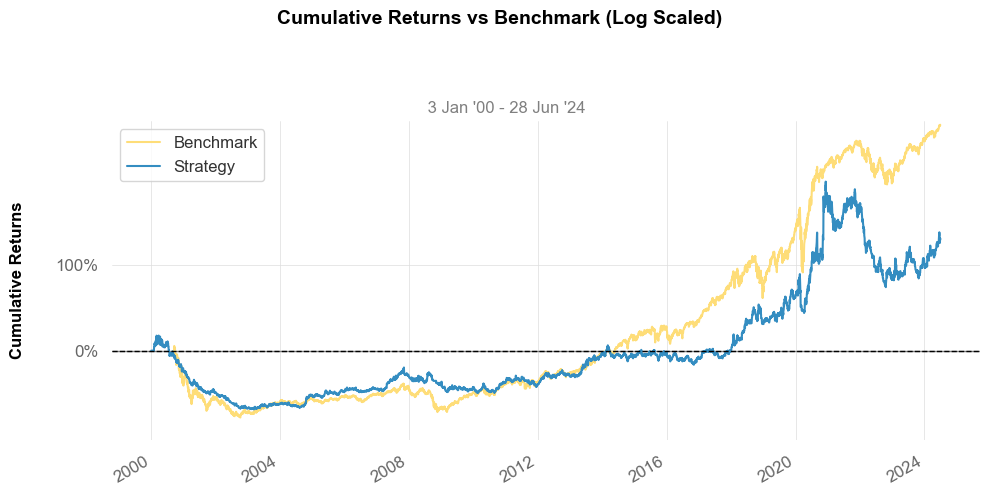

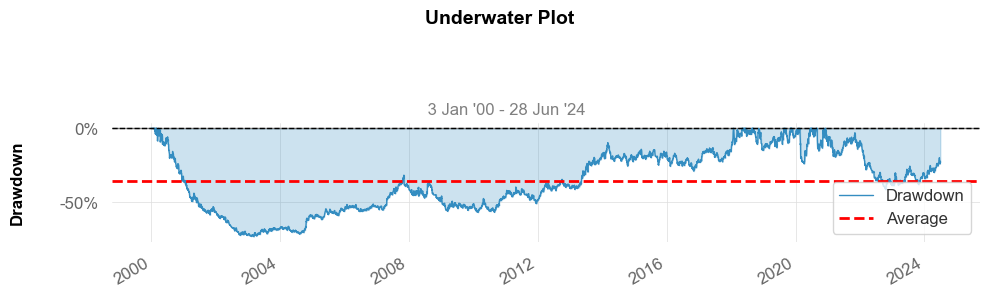

In [63]:
import sys
sys.path.append('/Users/dongin/Desktop/my-btester/myBtester')
from myBtester import Strategy
import talib
def UpBreakout(ser: pd.Series, period: int): return (ser.rolling(period).max().diff() > 0).values
def DownBreakout(ser: pd.Series, period: int): return (ser.rolling(period).min().diff() < 0).values

# newframe[t, 'S1_EL'] = newframe[t]['Close'].rolling(self.sys1_entry).max() 이거 기존 코드에서 > 0).value랑 무슨 차이임?
# newframe[t, 'S1_ExL'] = newframe[t]['Close'].rolling(self.sys1_exit).min()

class BreakoutStrategy(Strategy):
    def init(self, buy_period1: int, sell_period1: int, buy_period2: int, sell_period2: int):
        self.max_total_unit_risk = .01 # 거래당 1% 리스크 지는 것
        self.highpoint_of_account = 0 #초기 현금으로 최대 계좌 초기화
        self.account_pole = self.cash # 자산 최대값 기준로 리스크단위 증감 계산하기 위함 초기 계좌기준 10%씩 늘어나면 갱신하는 구조로할까

        self.buy_signal_system1 = {}
        self.buy_signal_system2 = {}
        self.sell_signal_system1 = {}
        self.sell_signal_system2 = {}
        self.atr = {}


        for symbol in self.symbols:
            self.atr[symbol] = talib.ATR(self.data[(symbol,'High')], self.data[(symbol,'Low')], self.data[(symbol,'Close')], timeperiod=20)

            self.buy_signal_system1[symbol] = UpBreakout(self.data[(symbol,'Close')], buy_period1)
            self.sell_signal_system1[symbol] = DownBreakout(self.data[(symbol,'Close')], sell_period1)

            self.buy_signal_system2[symbol] = UpBreakout(self.data[(symbol,'Close')], buy_period1)
            self.sell_signal_system2[symbol] = DownBreakout(self.data[(symbol,'Close')], sell_period1)

    def next(self, i, record):
        self.riskSize()

        for symbol in self.symbols:
            open_condition1 = self.buy_signal_system1[symbol][i-1]
            if open_condition1 and self.atr[symbol][i]>0:
                position_size = self.positionSize(record[(symbol,'Open')], self.atr[symbol][i])
                stop_loss = record[(symbol,'Open')]-self.atr[symbol][i]
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=position_size, stopLoss=stop_loss)

        for position in self.open_positions[:]:
            close_condition1 = self.sell_signal_system1[position.symbol][i-1]
            stoploss_condition1 = position.stopLoss > record[(position.symbol,'Open')]
            if close_condition1 or stoploss_condition1: self.close(position=position, price=record[(position.symbol,'Open')])

    def positionSize(self, price: float, atr: float): #전체 자산의 11% 감소한다면 리스크단위 규모는 20% 줄이는 로직 구현하기, 계속 변하는 자산의 고점을 알아야 함.
        if pd.isna(self.cash) or pd.isna(self.assets_value) or pd.isna(self.max_total_unit_risk) or pd.isna(atr): return 0
        return round((self.cash+self.assets_value) * self.max_total_unit_risk / (2*atr)) if price > 0 else 0

    def riskSize(self):
        self.highpoint_of_account = max(self.highpoint_of_account, self.cash+self.assets_value)
        if self.highpoint_of_account > self.account_pole * 1.11: self.account_pole *= 1.11
        # self.account_pole = self.highpoint_of_account
        condition1 = self.cash+self.assets_value < self.account_pole * (1-0.11)
        condition2 = self.cash+self.assets_value < self.account_pole * (1-0.22)
        condition3 = self.cash+self.assets_value < self.account_pole * (1-0.33)
        condition1_2 = self.cash+self.assets_value > self.account_pole * (1-0.22)
        condition2_3 = self.cash+self.assets_value > self.account_pole * (1-0.33)
        condition3_4 = self.cash+self.assets_value > self.account_pole * (1-0.44)
        if condition1 and condition1_2: self.max_total_unit_risk = .01*0.8          *(0.8*0.8*0.8*0.8)
        if condition2 and condition2_3: self.max_total_unit_risk = .01*0.8*0.8      *(0.8*0.8*0.8*0.8)
        if condition3 and condition3_4: self.max_total_unit_risk = .01*0.8*0.8*0.8  *(0.8*0.8*0.8*0.8)
        if not condition1: self.max_total_unit_risk = .01 # 다시 자산이 정상화되면 리스크 단위도 정상화


from btester import Backtest
backtest = Backtest(BreakoutStrategy, data2, commission=.001, cash=1e6)
result = backtest.run(20, 10, 55, 20)
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [23]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value,long,takeProfit,stopLoss
0,CRWD,2023-12-05,2023-12-29,233.960007,255.320007,4761,101694.962906,9.129766,1.215579e+06,NaN,None,227.194238
1,QCOM,2023-12-06,2023-12-29,131.979996,144.630005,12651,160035.265823,9.584793,1.829714e+06,NaN,None,129.408637
2,AMD,2023-12-08,2023-12-29,129.539993,147.410004,7737,138260.270279,13.794976,1.140511e+06,NaN,None,125.339045
3,META,2023-12-28,2023-12-29,359.700012,353.959991,4550,-26117.094421,-1.595780,1.610518e+06,NaN,None,352.173648
4,TSLA,2023-12-28,2023-12-29,263.660004,248.479996,3750,-56925.029755,-5.757418,9.318000e+05,NaN,None,254.531360
